In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import skimage
from skimage.transform import resize
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

from sklearn import svm

import cv2

import torch
from torchvision import models
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from PIL import Image

import sys

from sklearn.model_selection import train_test_split

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from skimage.transform import resize
from sklearn import svm

import torch
import torchvision
from torchvision import transforms
from PIL import Image
import time

In [2]:
# Setting input directory for bird and squirrel images

input_dir = '/kaggle/input/birds-and-squirrels/CV_data'

# listing possible image categories in folder
categories = ['Bird', 'Squirrel']

In [3]:

def prepare_images(input_dir, category):

  '''
  This function takes in the input directory and the category of the images and returns the images and their labels as a list.
  The function also resizes the images to 224x224 pixels and converts the image to grayscale.

  Args:

  input_dir: str: The directory where the images are stored
  category: str: The category of the images/labels of the folders that contain the images

  Returns:

  data_array: list: A list containing flattened image information

  labels_array: list: A list of the labels of the images
  '''

  # creating empty lists to store data and labels
  data = []
  labels = []

      # looping through Bird and Squirrel categories in the folder

  for category in categories:

      # looping through the images in each category

      for file in os.listdir(os.path.join(input_dir, category)):

          # reading the image

          image = imread(os.path.join(input_dir, category, file))

          # resizing the image

          image = resize(image, (224, 224, 3))

          #converting the image to greyscale

          image = skimage.color.rgb2gray(image)

          # normalizing the pixel values

          image = image / 255

          # flattening the image

          image = image.flatten()

          # append the image data to the list data

          data.append(image)

          # append the label to the list labels

          labels.append(category)

  # converting lists data and labels into numpy arrays
  data_array = np.array(data)
  labels_array = np.array(labels)

  # returning the completed arrays
  return data_array, labels_array

SVM Model Performance

In [4]:
def train_svm(data_array, labels_array):

  '''
  This function takes in the data and labels arrays and splits them into training and testing sets using sklearn's train_test_split
  20 percent of the data is used for testing and 80 percent for training
  The function then trains a support vector machine model using the training data and tests the model using the testing data
  The function then prints the accuracy, confusion matrix and classification report of the model
  The function returns the trained model

  Args:

  data_array: numpy array of the data
  labels_array: numpy array of the labels

  Returns: svm_model: trained support vector machine model
  '''

  # using train test split to split data into training and test sets

  X_train, X_test, y_train, y_test = train_test_split(data_array, labels_array, test_size=0.2, random_state=42, stratify=labels_array)

  # initializing the SVM model

  svm_model = svm.SVC(kernel='linear', C=1, gamma=1)

  # training the SVM model
  svm_model.fit(X_train, y_train)

  # making predictions on the test set
  y_pred = svm_model.predict(X_test)

  # printing accuracy, confusion matrix, and classification report

  CM = confusion_matrix(y_test, y_pred)

  print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))

  print(classification_report(y_test, y_pred))

  plt.figure(figsize = (10,7))

  s = sns.heatmap(CM, annot=True, fmt='d', cmap = "Blues")
  s.set(xlabel='Squirrel', ylabel='Bird')
    
  print(s)

  # returning trained svm_model

  return svm_model, X_test, y_test

Accuracy: 0.6
              precision    recall  f1-score   support

        Bird       0.59      1.00      0.75      1000
    Squirrel       1.00      0.05      0.10       720

    accuracy                           0.60      1720
   macro avg       0.80      0.53      0.42      1720
weighted avg       0.76      0.60      0.48      1720

Axes(0.125,0.11;0.62x0.77)


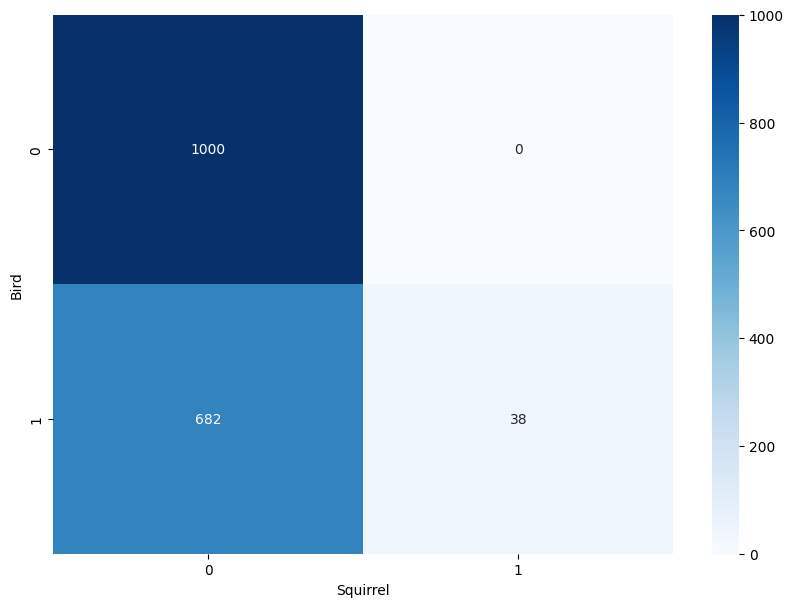

In [5]:
# preparing data using the prepare_images function above

data_array, labels_array = prepare_images(input_dir, categories)

# training the SVC model and printing results
svm_model, X_test, y_test = train_svm(data_array, labels_array)

In [ ]:
# Ouput Directory
output_dir = '/kaggle/working/'


# Saving Test Set Images for Use in Mean Model Comparison
for i in range(0, len(X_test)):

    plt.imshow(X_test[i].reshape(224,224), cmap='gray')
    plt.savefig(os.path.join(output_dir, f'Test_{i}.png'))
    plt.close()

Mean Model Comparison

In [ ]:
import re

def alex_net_model(X_test):

    '''

    This function calls a pretrained AlexNet model
    It runs the test images we created above through the network and generates predictions
    It then prints these classification predictions along with the probability percentage

    Args:

    X_test: numpy array of the test images

    Returns: None

    '''

    # initializing pretrained alexnet model
    model = models.alexnet(pretrained=True)
    # putting model in evaluation mode
    model.eval()

    # defining transforms that will be applied to the image

    preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225]
    )])

    # initializing empty list for storing predictions
    preds = []

    # calling classes used in alexnet model for labelling
    with open('/kaggle/input/document4/Doc4.txt') as f:
      classes = [line.strip() for line in f.readlines()]

      # iterate through images in Test_Images folder, transforming images, conerting to tensor, then
      # running through alexnet network and printing list of predictions along with image label

    for i in range(0, len(X_test)):

      test_image_path = f'/kaggle/working/Test_{i}.png'

      img = Image.open(test_image_path).convert('RGB')

      img_resized = img.resize((256,256))

      img_t = preprocess(img_resized)

      batch_t = torch.unsqueeze(img_t, 0)

      out = model(batch_t)

      _ , indices = torch.sort(out, descending = True)

      percentage = torch.nn.functional.softmax(out, dim = 1)[0]*100

      #print([(f'Test_{i}.png', classes[idx], percentage[idx].item()) for idx in indices[0][:1]])

      # print the predicted classes for every index in the list of predictions
      preds.append([(classes[idx]) for idx in indices[0][:1]][0])

    # stripping the numeric data from the string
    pattern = r'\d+:'

    preds = [re.sub(pattern, '', text) for text in preds]

    # Asked LLM to isolate the bird species from the AlexNet classes textfile

    bird_species = [
        'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch',
        'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie',
        'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture',
        'great grey owl', 'black grouse', 'ptarmigan', 'ruffed grouse',
        'prairie chicken', 'peacock', 'quail', 'partridge', 'African grey',
        'macaw', 'sulphur-crested cockatoo', 'lorikeet', 'coucal',
        'bee eater', 'hornbill', 'hummingbird', 'jacamar', 'toucan',
        'drake', 'red-breasted merganser', 'goose', 'black swan',
        'spoonbill', 'flamingo', 'little blue heron', 'American egret',
        'bittern', 'crane', 'limpkin', 'European gallinule', 'American coot',
        'bustard', 'ruddy turnstone', 'red-backed sandpiper', 'redshank',
        'dowitcher', 'oystercatcher', 'pelican', 'king penguin', 'albatross'
    ]

    # Asked LLM to isolate the squirrel species from the AlexNet classes textfile

    squirrel_species = [
        'squirrel', 'fox squirrel', 'marmot'
    ]

    # going through and reclassifying predictions as either bird, squirrel, or other
    pred_classes = []

    for pred in preds:
      for bird in bird_species:
        if bird in pred:
          pred_classes.append('Bird')
          break
      else:
        for squirrel in squirrel_species:
          if squirrel in pred:
            pred_classes.append('Squirrel')
            break
        else:
          pred_classes.append('Other')

    # calculating accuracy, printing confusion matrix, and printing classification report
    CM = confusion_matrix(pred_classes, y_test)

    print("Accuracy:", round(accuracy_score(pred_classes, y_test), 2))
    
    print(classification_report(pred_classes, y_test))

    
    s = sns.heatmap(CM, annot=True, fmt='d', cmap = "Blues")
    s.set(xlabel='Squirrel', ylabel='Bird')
    
    print(s)
        
    #returning purely text predictions
    return preds


In [ ]:
# running alexnet mean model

preds = alex_net_model(X_test)